In [1]:
import mne
#import matlab.engine
import numpy as np
import pandas as pd
from glob import glob

# For custom codebase
import sys
sys.path.insert(0, 'C:\\Users\\esolo\\Documents\\Python Scripts\\lib\\')
from codebase import *

# For parallel processing
import multiprocessing as mp
n_cpus = mp.cpu_count()

### MATLAB within Python

In [223]:
path = 'C:/Users/esolo/Documents/Python Scripts/TMSEEG_neuralynx/'
sub = '404'
tmseeg_fnames = glob(path+sub+'/404_020_TMS1/2017-11-13_14-28-23/LFP*ncs')

In [3]:
eng = matlab.engine.start_matlab()  #start the MATLAB engine

# Set some variables
eng.workspace["workingdir"] = path+sub+'/404_019_TMS1/2017-11-13_14-24-01/'
eng.workspace["ft_path"] = 'C:/Program Files/MATLAB/R2022a/fieldtrip-20220104/'

# Add FieldTrip to path (might need to be done with every new kernel?)
eng.eval('addpath(ft_path)', nargout=0)
eng.eval('ft_defaults', nargout=0)

# Get the Neuralynx LFPs
eng.eval('cd(workingdir)');
eng.eval('names = dir("LFP*ncs")', nargout=0);
eng.eval('fnames = {names.name}', nargout=0)

In [ ]:
# Read out the data
data = eng.eval('ft_read_neuralynx_interp(fnames)')

### Read the data using MNE

1. Load session-level metadata from the master CSV file (e.g. stimulation target, directory names, target localization, motor thresholds, etc. 
2. Load EEG data from the .data MAT file output by FieldTrip (MNE cannot yet directly read NLX directories)

Raise a warning if NaNs have been detected in the data; this should be rare and handled via linear interpolation in the FieldTrip step. 

In [2]:
import warnings
warnings.filterwarnings("ignore")  # for the annoying pandas deprecation warning

# Load the master CSV file with session metadata
root = 'D:/'
master = pd.read_csv(root+'master.csv')

# Get the session metadata
sub = 593
sess_num = 0
sess_meta = master[master['subject']==str(sub)].iloc[sess_num]
sess_name = sess_meta['session_name']
sess_type = sess_meta['session_type']

# Get the ECoG data from pre-saved FieldTrip data structure (a .mat file in the session directory)
from mne.io import read_raw_fieldtrip
raw = read_raw_fieldtrip(root+str(sub)+'/'+sess_name+'/data.mat', info=None);

# Raise a warning if NaNs are detected in the data
my_nans = np.isnan(raw.get_data()).sum()
if my_nans>0:
    print('WARNING: NaNs detected!')

Creating RawArray with float64 data, n_channels=256, n_times=1023994
    Range : 0 ... 1023993 =      0.000 ...   127.999 secs
Ready.


Assign channel type labels; assume all are ECoG to start and re-set depths in the next step. 

In [3]:
# Create dictionary of channel types
ch_types = {}
for ch_name in raw.ch_names:
    ch_types[ch_name] = 'ecog'
    
# Set channel types
raw.set_channel_types(ch_types)

# Get some info
native_sampling = raw.info['sfreq']

1. Load channel information from the supplied CSV files. In general, we will use the "surfaceRAS" files which snap ECoG grids/strips to the cortical surface and leave the depths untouched. However, parcellation information is only available in the "Contacts.csv" file, so the datasets have to be merged. (In some cases, RAS-snap information is not available, in which case we fall back to the standard "Contacts.csv" file. 

2. Drop any channels which were loaded by FieldTrip but not included in the .CSV files, as they are mostly likely bad or unconnected. 

3. Re-reference the depth electrodes using a standard bipolar montage (e.g. the difference of all neighboring electrodes). MNE handles most of this automatically and re-labels the channels. We then assign these channels as 'sEEG' type. Note that localization information for the bipolar electrodes is inherited from the anode's localization, but the MNI/avg coordinates reflect the average from the constituent monopolar contacts. (At some point, the localization pipeline should be re-run with the bipolar midpoint as ground truth). 

4. Remove "bad" channels as defined in the master.csv file, including any bipolar electrode which contains at least one "bad" channel.

5. Perform a common-average re-reference on the ECoG channels, and finally, reconstruct the contacts DataFrame using the bipolar pairs we just created. 

In [4]:
# Load channel info

# Apparently we use the RAS coordinates (e.g. snapped to cortical surface) for ground-truth electrode locations, but get the localization data from the '_Contacts.xls' file. So need to combine across 2 CSVs
import pandas as pd
contacts = pd.read_csv(root+str(sub)+'/'+str(sub)+'_Contacts.csv')  # with localization info
try:
    RAScoords = pd.read_csv(root+str(sub)+'/'+str(sub)+'_Contacts_surfaceRAS.csv')  # the proper RAS coordinates to use -- sometimes not available.
    haveRAS = True
except:
    haveRAS = False
    pass

# Merge into one master table if RAS coords are available. WARNING: This step requires the tables to be ordered identically! 
merged_contacts = contacts.copy()
if haveRAS:
    merged_contacts[['mniX', 'mniY', 'mniZ']] = RAScoords[['mniX', 'mniY', 'mniZ']]
    merged_contacts[['anatX', 'anatY', 'anatZ']] = RAScoords[['anatX', 'anatY', 'anatZ']]
else:
    pass

# Get list of channels to keep and drop (Neuralynx files sometimes contains disconnected channels, so the CSV file takes precedence)
chan2keep = ['LFPx'+str(i) for i in list(merged_contacts['Channel'])]
chan2drop = [c for c in raw.ch_names if c not in chan2keep]
chan2drop_alt = [c for c in chan2keep if c not in raw.ch_names]  # rarely, a channel is asked for by the CSV file which was not in the NCS directory
chan2keep_final = [c for c in chan2keep if c not in chan2drop_alt]
for c in chan2drop_alt:  # drop channels from the metadata if absent from the NCS directory (so it will not be used to construct bipolar pairs)
    idx = merged_contacts[merged_contacts['Channel']==int(c.split('x')[-1])].index[0]
    merged_contacts.drop([idx], inplace=True)

# Drop unused channels
raw.drop_channels(chan2drop)
raw.reorder_channels(chan2keep_final)

# Bipolar re-reference depth electrodes
depths = merged_contacts[merged_contacts['Group'].str.contains('depth', case=False)]
a, c = construct_bipolar_montage(depths)
raw_bp = mne.set_bipolar_reference(raw, anode=a, cathode=c, ch_name=None, drop_refs=True, copy=True, verbose=False)
bpchans = [s for s in raw_bp.ch_names if '-' in s]  # Get the list of bipolar electrodes -- the names will all be hypenated!
raw_bp.set_channel_types( dict( list( zip(bpchans,['seeg']*len(bpchans)) ) ) )  # reset the depth electrodes as type 'seeg' so we can reference the corticals seperately

# Drop bad channels after bipolar re-referencing to avoid creating weird bipolar pairs
try:
    bad_names = remove_bad_chans(sess_meta['remove_channels'].split(';'), raw_bp.ch_names)
    raw_bp.drop_channels(bad_names)
except:
    pass

# Common average re-reference cortical electrodes
corticals = merged_contacts[merged_contacts['Group'].str.contains('^(?!.*depth)', case=False, regex=True)]
avg_chans = ['LFPx'+str(i) for i in corticals['Channel']]
if len(avg_chans)==0: # if the subject is only depth electrodes
    raw_bp_avg = raw_bp.copy()
else:
    raw_bp_avg, _ = mne.set_eeg_reference(raw_bp, ref_channels='average', ch_type='ecog', copy=True, verbose=False)
    
# Reconstruct the contacts DataFrame
new_contacts = reref_contacts_frame(merged_contacts, raw_bp_avg.ch_names)

# Delete unneeded data as these files can be big! 
del raw_bp

Visually inspect the average EEG trace across all channels to ensure the automated trigger detection algorithm is working properly. (Should handle most cases very well; basic logic is to (1) take the first-order difference of the signal and (2) use peak detection to identify peaks, including knowledge that peaks should be at least 2 seconds apart and setting a 25% threshold of the maximum observed amplitude.) 

Ideally, trigger detection would happen via an input channel which contains the stimulation trace itself, but it appears this is usually not available. 

157 triggers identified.


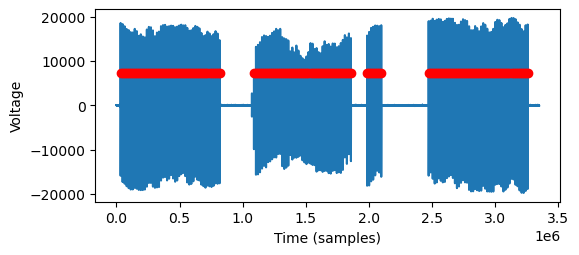

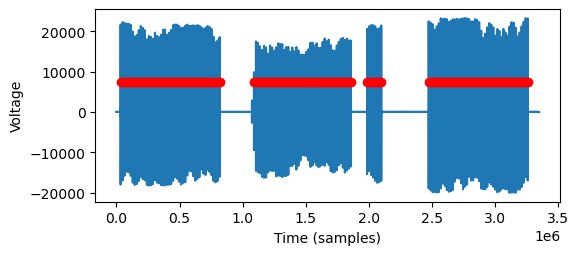

In [6]:
import pylab as plt
%matplotlib inline

# Get the trigger times from the data itself (is there a better way to do this?)
from scipy.signal import find_peaks

# Set some params
ord_diff = 1  # may need to take differential to better detect peaks
thresh_pct = 0.15   # fraction of maximum amplitude to use as threshold for peak detection

# Preload data to run this script faster
if 'raw_traces' in globals():
    pass
else:
    raw_traces = np.nanmean(raw.get_data(), 0)

# Detect stimulation peaks (better to use un-rereferenced data)
trg = np.diff(raw_traces, ord_diff)  #find triggers in the mean EEG
thresh = thresh_pct*np.nanmax(trg) #take the threshold as % of the max value
pk, _ = find_peaks(trg, height=thresh, distance=native_sampling/2)  #find the trigger peaks
print(str(len(pk))+' triggers identified.')

# Plot the triggers
plt.figure(figsize=(6, 2.5));
plt.plot(raw_traces)
plt.plot(pk, [thresh*2.1]*len(pk), 'ro')
plt.xlabel('Time (samples)'); plt.ylabel('Voltage');

# Now w/ first order differential
plt.figure(figsize=(6, 2.5));
plt.plot(np.diff(raw_traces))
plt.plot(pk, [thresh*2.1]*len(pk), 'ro')
plt.xlabel('Time (samples)'); plt.ylabel('Voltage');

#np.save(root+str(sub)+'/'+sess_name+'/trigs.npy', pk)

try:
    del raw
except NameError:
    pass

In [16]:
len(pk)

150

Code that identifies "gaps" between blocks of stim/sham and assigns them as stim/sham events based on the data included in the master CSV file. Allows user to visually inspect to ensure the gaps were detected properly. 

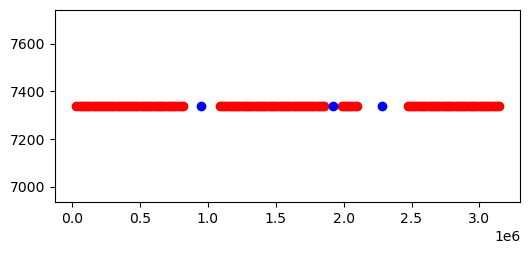

In [14]:
typs = sess_type.split(';')
if len(typs)==1:  # no need to identify TMS vs sham events within a single file
    evs = dict(zip(pk, typs*len(pk)))   
else:
    # Find where the session flips from one type to another (look for large gaps between pulse blocks)
    pk_diff = np.diff(pk)
    gaps = np.where(pk_diff>4*native_sampling)[0]
    gap_midpoint = []
    for i in gaps:
        gap_midpoint.append(pk[i]+int(pk_diff[i]/2))
        
    # Plot the triggers + gap midpoint
    plt.figure(figsize=(6, 2.5));
    #plt.plot(np.nanmean(raw_bp_avg.get_data(), 0))
    plt.plot(pk, [thresh*2.1]*len(pk), 'ro')
    plt.plot(gap_midpoint, [thresh*2.1]*len(gap_midpoint), 'bo')
    
    np.save(root+str(sub)+'/'+sess_name+'/gap_midpoints.npy', gap_midpoint)
    
    if len(gap_midpoint)!=(len(typs)-1):
        print('WARNING: Gaps and session types do not match!')

    # Create event dictionary for each stimulation event based on the gaps between stim blocks
    g = 0  # to track the gaps we run through
    evs = []
    if len(typs)==2:
        pks1 = pk[pk<gap_midpoint[g]]
        evs.extend(zip(pks1, [typs[0]]*len(pks1)))
        pks2 = pk[pk>gap_midpoint[g]]
        evs.extend(zip(pks2, [typs[1]]*len(pks2)))
    if len(typs)>2:
        for t in typs:
            if g==0:
                pksUse = pk[pk<gap_midpoint[g]]
                evs.extend(zip(pksUse, [t]*len(pksUse))) 
                g = g+1
            else:
                try:
                    pksUse = pk[(pk<gap_midpoint[g]) & (pk>gap_midpoint[g-1])]
                except:
                    pksUse = pk[pk>gap_midpoint[g-1]]
                g = g+1
                evs.extend(zip(pksUse, [t]*len(pksUse)))        
    evs = dict(evs)

In [9]:
# Complete creation of an Events dataframe
Events = pd.DataFrame()

for k in evs.keys(): 
    mydict = {'sample': k, 'type': evs[k]}
    mydict.update(sess_meta[['session_name', 'target', 'target_contact', 'cutaneous_sham', 'machine_threshold', 'avg.x', 'avg.y', 'avg.z', 'frequency', 'auditory']])
    Events = Events.append(mydict, ignore_index=True)

In [10]:
# Filtering steps: (0) high-pass filter 0.1 Hz, (1) scrub stim artifact, (2) Notch, (3) Downsample, (4) optional: 35Hz low-pass (for ERPs)
raw_bp_avg = raw_bp_avg.filter(h_freq=None, l_freq=0.1, n_jobs=n_cpus, verbose=False)

# Scrub artifact and re-create Raw object
eeg_array = raw_bp_avg.get_data()
for c in range(eeg_array.shape[0]):
    eeg_array[c, :] = interpolate_stim(eeg_array[c, :], Events['sample'], sfreq=raw_bp_avg.info['sfreq'])
scrub = mne.io.RawArray(eeg_array, info=raw_bp_avg.info)

Creating RawArray with float64 data, n_channels=206, n_times=902144
    Range : 0 ... 902143 =      0.000 ...   112.768 secs
Ready.


In [11]:
#scrub = scrub.resample(sfreq=1000, n_jobs=n_cpus, verbose=False)  # rarely, may need to downsample to 1000Hz before notching due to memory limits in large files

nfilt = scrub.notch_filter(freqs = [60, 120, 180], method='spectrum_fit', n_jobs=n_cpus, verbose=False)  # notch out the line noise

fs = 500  # resample to 500Hz (MNE will automatically low-pass to avoid aliasing)
nfilt_rs = nfilt.resample(sfreq=fs, n_jobs=n_cpus, verbose=False)

# Note that the Events sample times will need to be adjusted after downsampling step (careful not to re-run this line!)
dsample = int(native_sampling/fs)
adj_samps = np.array(Events['sample']/dsample)
Events['sample'] = adj_samps.astype(int)

# Optional: 35 Hz low-pass for ERP analysis
#lp = nfilt_rs.copy().filter(h_freq=35, l_freq=None, n_jobs=n_cpus, verbose=False)

In [12]:
# Restructure into EpochsArray object
mne_events = np.empty([len(Events), 3])
mne_events[:, 0] = Events['sample']  # the timepoints for each event in samples
mne_events[:, 1] = 0  # unsure what the column does exactly, probably OK to be zero per MNE documentation
mne_events[:, 2] = np.array([0 if i=='sham' else 1 for i in list(Events['type'])]) # the type of event, encoded as a variable. We'll use 0 for sham and 1 for TMS

# MNE can only take event dictionaries for event types native_samplingually exist in the current dataset (annoying)
if (1 in mne_events[:, 2]) and (0 not in mne_events[:, 2]):  
    event_id = {'tms':1}
elif (1 not in mne_events[:, 2]) and (0 in mne_events[:, 2]):
    event_id = {'sham':0}
else:
    event_id = {'sham':0, 'tms':1}

epochs = mne.Epochs(nfilt_rs, events=mne_events.astype(int), event_id=event_id, tmin=-0.5, tmax=2.0, metadata=Events, baseline=None, 
                   reject_by_annotation=False)

Adding metadata with 12 columns
50 matching events found
No baseline correction applied
0 projection items activated


In [15]:
epochs.plot(scalings='auto')

Using data from preloaded Raw for 48 events and 1251 original time points ...
Using qt as 2D backend.
Opening epochs-browser...
Using data from preloaded Raw for 20 events and 1251 original time points ...
Using data from preloaded Raw for 5 events and 1251 original time points ...
Using data from preloaded Raw for 5 events and 1251 original time points ...
Using data from preloaded Raw for 5 events and 1251 original time points ...
Using data from preloaded Raw for 5 events and 1251 original time points ...
Using data from preloaded Raw for 5 events and 1251 original time points ...
Using data from preloaded Raw for 20 events and 1251 original time points ...
Using data from preloaded Raw for 5 events and 1251 original time points ...
Using data from preloaded Raw for 5 events and 1251 original time points ...
Using data from preloaded Raw for 20 events and 1251 original time points ...
Using data from preloaded Raw for 5 events and 1251 original time points ...
Using data from preloa

Using data from preloaded Raw for 5 events and 1251 original time points ...
Closing epochs-browser...
Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none


In [14]:
# Save the result
epochs.save(root+str(sub)+'/'+sess_name+'/processed_epo.fif', overwrite=True)
new_contacts.to_pickle(root+str(sub)+'/'+sess_name+'/contacts.pkl')

Using data from preloaded Raw for 50 events and 1251 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 1 events and 1251 original time points ...
Using data from preloaded Raw for 50 events and 1251 original time points ...
